In [38]:
## This code is meant to be run with SageMath (tested with version 9.2) and will generate the c++ files necessary to run an optimization with Sandia's Dakota toolkit (tested with version 6.13)
# the equations and results coming from this optimization can be seen in the (currently accepted by the Journal of Applied and Computational Mechanics) paper: "Parametric optimization of a cyclogiro aircraft design for efficient hover with aeroelastic considerations" by Louis Gagnon, Marco Morandini, and Stéphane Fournier

## initial tuning of the notebook:

## make cells larger for better visibility:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important;}</style>"))

# turn off automatic parentheses:
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

# word-wrap the cell lines:
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"lineWrapping": True}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'Notebook': {'Header': False},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False, 'lineWrapping': True}}}

In [39]:
# defining all variables and basic parameters
reset()
var('mu, CT_par', domain='real')
var('X3', domain='real') # theta_c for dakota
var('kappa, a, sigma, Cd, theta_c', domain='positive')
var('rho, Omega, R, c, b, N, N_n, r_s, T, A_b, C_L, m', domain='positive')
#var('X1, X2, X4', domain='positive') # c, N, R for dakota
var('m, m_b, m_s, h_s, h_b, t_s, E_b, E_s, J_b, J_s, I_b_A, I_b_B_nose, I_b_B_p, I_b_B_nose_pi, I_b_B_p_pi, EJ_e, rho_pla, rho_s, p_i, K_a, K_b, nu_b, x_p, x_cg, x_n, p_i_rod, A_rod, R_rod, d_rod, b_rod, r_rod, eta_s, sigma_rod_y, p_i_fr, R_fr1_i, R_fr1, R_fr2_i, R_fr2', domain='positive')
var('q_w, w, A, y', domain='real')
var('t,phi,n_b_t,t_bt,r_t_bt', domain='positive')
simSup = bool(1) # is simply supported
RF = RealField(128)
N_n = 12; # naca number (4-number system, those after the 00, symmetric only, used for height and lift calculation)
optimRun = bool(0) # true to run an optimization equation generating process (ie skip numerical setting of values)
getCPP = bool(0) # c++ generator
postRun = bool(1) # run as post dakota run thus using the soln values from the dakota result

In [40]:
### je pars de la feuille "AEAT-corr 27 sept. 2016" je fais un calcul rapide d'optimization des prestations du drone
## data of interest: weight, vertical lift, consumed energy, max load, energy cost of payload...
##
### HOVER (U = mu = 0 , CT_rp = CT_par)
##
#
eq1_RP = (( 4*CT_par/(sigma*a)  - mu - kappa*mu/2 - theta_c - Cd/(sigma*a)*(mu+kappa*mu/2))/((Cd/(sigma*a)+1)*kappa))^2 - ((mu/2)^2+pi*CT_par/2) == 0 ## reverse propulsion
CT_RP=solve(eq1_RP,CT_par)
CT_RP_Root1=CT_RP[0].rhs()
C_T = CT_RP_Root1

In [41]:
Lambda = sqrt(pi*C_T/2); ## hover
alpha_m = theta_c-atan(Lambda); # max angle of attack encountered, must be below 13.06 deg
f_a = rho/2*(Omega*R)^2*c*C_L # aerodynamic forces (maximum), per unit span, on blade, AIAA submission, eq (1) (assumes perpendicular flow)
f_d = rho/2*(Omega*R)^2*c*Cd # drag forces (max) on blade, assumes perpendicular flow
F_r_x0 = (Cd - a/2*Lambda^2 + a/2*Lambda*theta_c) * rho/2*(Omega*R)^2*c*b #CORRECTION_MARS2021# calculated for hover (mu=0), eq. 69 AEAT ---> Changed by removing f_a which brought unwillingly C_L inside
F_T = C_T/N * rho*(Omega*R)^2*2*pi*R*b # from eqs. 4-5 AEAT, thrust per blade --> #CORRECTION_MARS2021## added division by N because C_T is Thrust per rotor (N)
P = F_r_x0 * R * Omega; # power per blade
M_a = 1/4 * 25.0 * (b/0.24*c/0.06); # based on Roskam wing weight (f(blade area)) and Meinhard's weight of L1, from IMSD, want mass < 25kg (EASA); ATTN: this is 1/4 of whole aircraft weight
F_Tu_simple = F_T*N - M_a*9.81; # multiplied by N to get per rotor value (ie: 1/4 of aircraft effective thrust)#CORRECTION_MARS2021## F_T was corrected to be per blade
# now going into structural/aeroelastic analysis
eta_s = 1.2 # safety factor for the rod
sigma_rod_y = 23*10^6 # yield stress (at 100% infill, worst than at 90%)
sigma_fr_y = 10^6*(8 + 20 * (p_i_fr-10)/80) # frame beam yield stress (valid from 10% up to 90% infill, worst at 100%), from data at http://my3dmatter.com/wp-content/uploads/2015/03/infillpercentyield.png
sigma_b_y = 10^6*(8 + 20 * (p_i-10)/80) # idem for blade yield
sigma_s_y = 240 * 10^6 # yield strength of alumninum spar, assuming 6061-T6 (IMPORTANT)
h_b = N_n/100 * c # height of blade taken from NACA number and chord
h_f = (3*2*0.4/1000) # height of top+bottom 100% filled printed 0.4mm layers, limited to blade height
minC = (3*2*0.4/(N_n/100))/1000 # minimum acceptable chord to respect 3 layers filled portion (otherwise need to switch back to min() formulation above which causes impoosibility to integrate, and thus need to choose size range before optimizing...)
assume(c > minC)
h_s = h_b - h_f # taking off 3 printed layers at 0.4mm each at the top and bottom of the blade
t_s = h_s*r_s # thickness of spar, function of spar width (thickness) to height ratio
K_a = 0.6 # area constant for airfoils from "Wing Bending Calculations" (web resource)
J_b = 0.036*c*h_b^3# OLD blade second moment of area, simplified J from "Wing Bending Calculations" (web resource)
J_s = t_s*h_s^3/12 # spar section second moment of area about centroid line
c_i_o = c-h_f # chord of inner area, overestimated
c_i_u = (h_b - h_f)/(N_n/100) # chord of inner area, underestimated
h_b_i = h_s # height of inner area (less than 100% filled)
m_b = K_a*(c*h_b-c_i_u*h_b_i*(100-p_i)/100)*rho_pla # mass per unit span ajusted conservatively (overestimating it) for the percent infill (verified by 20oct2016 plots, see journal)
if (1): # if true use real area instead of approx one, and also real I_b and K_b
    x_n=0 # blade nose x position
    x_n_pi=0 # blade nose x position of p_i blade, w.r.t. itself
    d_naca = 0.4015 # dst. btwn leading edge and center of mass for sym. naca blades as fraction of chord
    x_cg = d_naca*c # center of mass position along x, valid for all symmetric NACA profiles, see sheet airfoilCenterOfMassClean or related blog post
    f_x = 5*(N_n/100)*c*(0.2969*(x/c)^0.5 - 0.126*(x/c) - 0.3516*(x/c)^2 + 0.2843*(x/c)^3 -0.1036*(x/c)^4)
    f_x_pi = 5*(N_n/100)*c_i_u*(0.2969*(x/c_i_u)^0.5 - 0.126*(x/c_i_u) - 0.3516*(x/c_i_u)^2 + 0.2843*(x/c_i_u)^3 -0.1036*(x/c_i_u)^4) # function for inner blade (p_i)
    A_b = integrate(2*f_x,x,0,c)
    A_b_pi = integrate(2*f_x_pi,x,0,c_i_u) # area of inner blade (p_i)
    K_a = A_b/(N_n/100*c^2)
    I_b_A = integrate(integrate(y^2,y,-f_x,f_x),x,0,c) # second moment of area of a section about chord (see 30Nov2016p3 notes for nomenclature)
    I_b_B_nose_f = rho_pla*integrate(integrate((x^2+y^2),y,-f_x,f_x),x,0,c) # moment of inertia per unit span about nose of blade (see 30Nov2016p3 notes for nomenclature), filled blade
    I_b_B_nose_pi_indet = p_i/100*rho_pla*integrate(integrate((x^2+y^2),y,-f_x_pi,f_x_pi),x) # moment of inertia per unit span about nose of inside (p_i) blade
    I_b_B_nose_pi = I_b_B_nose_pi_indet(x=c_i_u) - I_b_B_nose_pi_indet(x=0) # determinate integral must be divided for SageMath >= 9...
    I_b_B_p = I_b_B_nose_f + rho_pla*A_b*((x_p-x_cg)^2-(x_cg-x_n)^2) # moment of inertia per unit span about pivot point (see 30Nov2016p3 notes for nomenclature)
    I_b_B_cg_f = I_b_B_nose_f - rho_pla*A_b*(x_n-x_cg)^2 # moment of inertia of filled blade per unit span about centroid
    I_b_B_cg_pi = I_b_B_nose_pi - p_i/100*rho_pla*A_b_pi*((d_naca*c_i_u)^2-(d_naca*(c-c_i_u)-h_f/2)^2) # moment of inertia per unit span of internal blade (p_i) about centroid of external blade
    I_b_B_cg = I_b_B_cg_f - I_b_B_cg_pi*(100/p_i-1) # resulting I for the balde with filled edge layers and p_i filled inside
K_b = 4*I_b_A/(1+16*I_b_A/(K_a*h_b*c^3)) # blade's Torsion factor; from "Young2011_FormulasforStressandStrain", pdf also in email Marco 18 Nov. 2014 (Roark's Formulas for Stress and Strain)
E_b = 10^9*(0.6 + 2.5 * (p_i-10)/90) # estimating Young's modulus as fraction of intact one based on infill percentage (p_i) (actually, the real scenario will be more rigid because the outter layers are all 100% filled, and are the most important ones (for J)); function derived from http://my3dmatter.com/influence-infill-layer-height-pattern/ valid for 10-100%
E_rod = 10^9*(0.6 + 2.5 * (p_i_rod-10)/90) # idem, for pivot rod
E_fr = 10^9*(0.6 + 2.5 * (p_i_fr-10)/90) # idem, for frame beam
nu_b = 0.37 # conservative (high) estimate of Poisson's ratio for PLA (actually using polycarbonate)
G_b = E_b/(2*(1+nu_b)) # modulus of rigidity of blade (PLA) based on the p_i influenced Young's modulus
EJ_e = E_b*I_b_A+E_s*J_s; # equivalent EJ (flexural rigidity) for composite beam (assumes perfectly glued)
m_s = t_s*h_s*rho_s # spar mass per unit span
m = m_b + m_s # total blade+spar mass per unit span
if (simSup):
    q_w = R*Omega^2 * (4/pi*(1+1/2*A))/(pi^4*EJ_e/(m*b^4)-Omega^2*(1+A)); # simply supported blade, from eq. 10 AIAA as submitted
    q_w = q_w.subs(A=rho*c*C_L*R/m)
    w = cos(pi/b*x)*q_w
epsilon_b = h_b*derivative(derivative(w,x),x) # max absolute strain in blade
epsilon_s = h_s*derivative(derivative(w,x),x) # max absolute strain in spar
sigma_b = E_b*epsilon_b # maximum absolute axial stress in blade (compression or tension)
sigma_s = E_s*epsilon_s # maximum absolute axial stress in spar (compression or tension)
M = EJ_e*derivative(derivative(w,x),x) # bending moment in beam
V = derivative(M,x) #
phi_b = (cos(Omega*sqrt(I_b_B_cg/(K_b*G_b))*x)+tan(Omega*sqrt(I_b_B_cg/(K_b*G_b))*b)*sin(Omega*sqrt(I_b_B_cg/(K_b*G_b))*x)-1)*theta_c*cos(Omega*t) ## eq. for difference of angle between attachment point and free blade edge of excited cycloidal rotor blade (see calculations ending on p.6 of 28nov2016) (to take in consideration a 2nd harmonic pitching, simply add it to the time dependent function (see notes 1dec2016p1)
phi_b_max = phi_b.subs(x=b,t=0) # max angle diff. along blade with imposed angle in torsion; see notes of 30nov2016p4 for justification about location (x=b) which will hold for all ang. vels. below nat. freq. (note: here b is end of blade, unlike for formulas of AEAT, check)
n_b_t = pi/(2*b) * sqrt(K_b*G_b/I_b_B_cg) # blade natural frequency in torsion (see hand notes of 30nov2016p4, or better: 7feb2017p2)
r_t_bt = asec(1+t_bt)*2/pi # ratio of freq/natFreq where threshold gets exceeded at blade tip, corrected
x_b_max = 0.299473201701467 # position (as fract. of c) of maximum height, see "extending, dec2016" section of "airfoilCenterOfMassClean" sagemath sheet for numerical solution, will hold for any symmetrical NACA blade
r_curv_b = -26.4282690955135/(N_n*c) # curvature of blade at point of max inscribed circle, see "extending, dec2016" section of "airfoilCenterOfMassClean" sagemath sheet for sln, will hold for any symmetrical NACA blade
C_y = h_b/(1+(pi^2*h_b^4)/(16*A_b^2)) * (1+0.15*((pi^2*h_b^4)/(16*A_b^2)-h_b/(2*r_curv_b))) # from Young, torsion table
tau_b_m = G_b*phi_b_max/b*C_y# maximum stress in blade due to torsion (uncoupled analysis), formula from Young,
f_c = m*Omega^2*R # centrifugal forces on blade, per unit span, AIAA submission, eq (1) (modified to include spar)
f_rod_max = (f_c + f_a)*b/2 # maximum force acting axially on one rod which holds blade and imposing rotation (assuming f_a always smaller than f_c) and also assuming pitch rods are not helping (nor harming)
T_motor = 4*P*N/Omega # total motor torque, assuming best RPM/power match
T_rod = P/Omega/2 # per blade power gives per blade torque, assuming two rods per blade and ideal motor/transmission conditions (assuming that rods that transmit power are two per blade, left and right)
# latest calculation, opting for constraint approach, for the pivot rod dimensions
sigma_rod_c1 = eta_s/A_rod*(f_rod_max+T_rod*6*sqrt(r_rod/A_rod)) - sigma_rod_y # constraint to remain below zero for feasible design


In [42]:
epsilon_rod = f_rod_max/A_rod/E_rod # strain ratio of the pivot rods
d_rod = sqrt(A_rod/r_rod) # pivot rod long edge (height)
b_rod = r_rod*d_rod # pivot rod small edge (width)
I_rod = b_rod*d_rod^3/2# Young p.pdf.804 (skipped filled minus p_i_rod inner portion of beam)
w_rod = T_rod*b_rod^2/(3*E_rod*I_rod) # max rearward deflection of rod (at pivot point), corrected
sigma_rod = f_rod_max/A_rod + T_rod*d_rod/2/I_rod # combined max stress inside rod
m_rod = A_rod*R*rho_pla # mass of pivot rod
m_rod_p = m_rod # mass of pitch rod (assuming equal to pivot rod for now, ideally would consider rotational inertia and aerodynamic forces)

In [43]:
### #CORRECTION_MARS2021## pour toute cette cellule (making two constraints [and two beams] on the stresses in the frame beams)
L_fr1 = R+c # inside span (half frame)
L_fr2 = b # outside span  (half frame)
L_fr = 2*(L_fr1+L_fr2) # full frame beam length, no collision plus very small separation [ie: percent of chord], but gap is so only small at the corner of the rotors)
I_fr1 = pi/4*(R_fr1^4)*p_i_fr/100 # revised version, see handwritten notes 13fev2017p1
I_fr2 = pi/4*(R_fr2^4)*p_i_fr/100 # revised version, see handwritten notes 13fev2017p1
F_fr = f_rod_max*4*N/6; # maximum possible force sustained by each frame arm at point of attachment with rotor (NOTE: that was assuming ONE point of attachment PER ROTOR, thus with two points of attachment each point we use F_fr/2) #CORRECTION_MARS2021##: ajoute aussi divison par 6!!!
M_fr1 = F_fr/2 * ((L_fr1+L_fr2) + L_fr1) # explicitly written, one load at each frame's/rotor's point of attachment
M_fr2 = F_fr/2 * L_fr2 # moments caused by the frame portion that goes through the rotor's span
#eqFrameYield = sigma_fr_y == F_fr * L_fr * R_fr / (4 * I_fr)
eta_s_b = 1.5 # safety factor for the frame beams
eqFrameYield_1 = sigma_fr_y == eta_s_b * M_fr1 * R_fr1 / I_fr1 #CORRECTION_MARS2021## 
eqFrameYield_2 = sigma_fr_y == eta_s_b * M_fr2 * R_fr2 / I_fr2 #CORRECTION_MARS2021##
w_fr_beam_1 = F_fr * L_fr1^3   / (3*E_fr*I_fr1)# half frame beam model deflection (static, max possible total blade thrust)
w_fr_beam_2 = F_fr/2 * L_fr2^3 / (3*E_fr*I_fr2)# half frame beam model deflection (static, max possible total blade thrust)
w_fr_beam = w_fr_beam_1 + w_fr_beam_2
RframeSln1 = solve(eqFrameYield_1,R_fr1)
RframeSln2 = solve(eqFrameYield_2,R_fr2)
for iFrame,aFrame in enumerate(RframeSln1): # finding Radius of frame by retaining only non-imaginary sln to cubic eqn (two roots are complex conjugates that have only Rframe=0 as non-imaginary solution; third root should always be real for physical input.)
    if not aFrame.has(I):
        print( 'FINDING null imaginary part of cube of Rframe1 solution ', iFrame, ', must be the only one or else error')
        R_fr1 = aFrame.rhs()
for iFrame,aFrame in enumerate(RframeSln2): # finding Radius of frame by retaining only non-imaginary sln to cubic eqn (two roots are complex conjugates that have only Rframe=0 as non-imaginary solution; third root should always be real for physical input.)
    if not aFrame.has(I):
        print( 'FINDING null imaginary part of cube of Rframe2 solution ', iFrame, ', must be the only one or else error')
        R_fr2 = aFrame.rhs()
R_fr1_i = R_fr1-0.4/1000*3 # frame beam's inner radius (taking off the 3 filled layers)
R_fr2_i = R_fr2-0.4/1000*3 # frame beam's inner radius (taking off the 3 filled layers)
m_fr = 2 * rho_pla * L_fr1 * pi*(R_fr1^2+R_fr1_i^2*(p_i_fr/100-1)) + L_fr2 * pi*(R_fr2^2+R_fr2_i^2*(p_i_fr/100-1)) # mass of one frame beam
#view(eqFrameYield)
soln = {}; # defining dictionary

FINDING null imaginary part of cube of Rframe1 solution  2 , must be the only one or else error
FINDING null imaginary part of cube of Rframe2 solution  2 , must be the only one or else error


In [44]:
if (postRun): # Final values for JACM article
    soln[c] =          2.0079621251e-02
    soln[theta_c] =    2.5938162467e-01
    soln[R] =          2.2194924572e-01
    soln[N] =          2.0000000000e+00
    soln[Omega] =      2.8193049874e+02
    soln[A_rod] =      1.9904560413e-06
    soln[b] =          3.8006475716e-02
    soln[p_i] =        9.0000000000e+01
    soln[p_i_fr] =     9.0000000000e+01
    soln[r_s] =        4.0000000000e-02

In [45]:
soln[kappa] = 1.48
soln[rho] = 1.204
soln[mu] = 0. # advance ratio
soln[a] = 5.5 # for NACA0012, conservative, with alpha_m_a
soln[sigma] = c*(N/(2*pi*R))
soln[C_L] = alpha_m*a # assuming, wrongfully but to be conservative, that C_L is from max angle of attack
soln[E_s] = 70.*10^9 # aluminum
soln[rho_s] = 2650.
soln[rho_pla] = 1250. # density of PLA
soln[t_bt] = 0.01 # threshold of admissible pitch angle multiplier at blade tip (see 1dec2016p1-2)
soln[p_i_rod] = 100. # pct infill of plastic rod (small, maybe always 100%?) ATTENTION: change code if not 100%)
soln[r_rod] = 1/4 # pivot rod thickness to height ratio

<>:10: DeprecationWarning: invalid escape sequence \c
<>:10: DeprecationWarning: invalid escape sequence \c
<ipython-input-46-f04223f1423f>:10: DeprecationWarning: invalid escape sequence \c
  p_fit = plot(model(x_fit).subs(solnFit),(x_fit,RealNumber('0.05'),Integer(8)),axes_labels=['$Reynolds/10^6$', 'Angolo di attaco massimale ammesso $(^\circ{})$']) # plot fitted curve


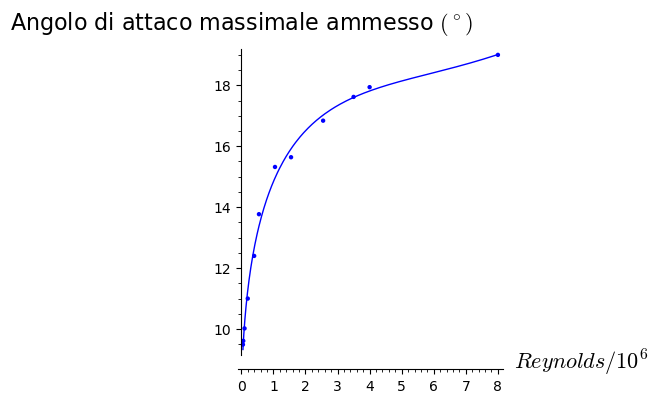

In [46]:
### Get Reynolds and dependant values (mAoA and Cd)
Reynolds =  Omega*R*c*6.8493e+04; # careful for Re < 1.6e5
if (1): # this is for a NACA0012 airfoil, calculations from 24 Oct. 2016 with XFLR5
    # first for mAofA (aka alpha_m)
    dataReAofA = [(0.05, 9.49),(0.06, 9.61),(0.55, 13.77),(1.05, 15.32),(3.50, 17.62),(4.00, 17.94),(1.55, 15.64),(2.55, 16.84),(0.20, 11.00),(0.10, 10.02),(0.40, 12.40),(8.00, 19.00)] # NACA0012
    p_pt = point(dataReAofA) # plot points
    var('a_coef, b_coef, c_coef, d_coef, e_coef, x_fit')
    model(x_fit) = a_coef + b_coef*x_fit^(1/2) + c_coef*x_fit + d_coef*x_fit^2
    solnFit = find_fit(dataReAofA, model, initial_guess=None, parameters=None, variables = [x_fit], solution_dict=true)
    p_fit = plot(model(x_fit).subs(solnFit),(x_fit,0.05,8),axes_labels=['$Reynolds/10^6$', 'Angolo di attaco massimale ammesso $(^\circ{})$']) # plot fitted curve
    (p_pt+p_fit).show() # show both plots
    alpha_m_a = model(Reynolds/10^6).subs(solnFit).subs(soln) # maximum admissible angle of attack (for NACA0012)
if (1):
    ### now for Cd, measure at alpha=5deg
    dataReCd = [(0.0400, 0.0287),(0.0600, 0.0217),(0.0800, 0.0186),(0.1000, 0.0168),(0.1300, 0.0151),(0.1600, 0.0140),(0.2000, 0.0131),(0.2500, 0.0123),(0.3000, 0.0117),(0.5000, 0.0104),(1.0000, 0.0085),(3.0000, 0.0068),(8.0000, 0.0069)] # naca0012
    p_pt2 = point(dataReCd) # plot points
    var('a_coef2, b_coef2, c_coef2, d_coef2, e_coef2, x_fit2, Cd_fit')
    model2(x_fit2) = a_coef2*x_fit2^(-1) + b_coef2 + c_coef2*x_fit2 + d_coef2*x_fit2^(1/2)
    solnFit2 = find_fit(dataReCd, model2, initial_guess=None, parameters=None, variables = [x_fit2], solution_dict=true)
    p_fit2 = plot(model2(x_fit2).subs(solnFit2),(x_fit2,0.04,8)) # plot fitted curve
    #(p_pt2+p_fit2).show() # show both plots
    Cd_fit = model2(Reynolds/10^6).subs(solnFit2).subs(soln) # Cd as f(Reynolds) (for NACA0012)    
    soln[Cd] = Cd_fit

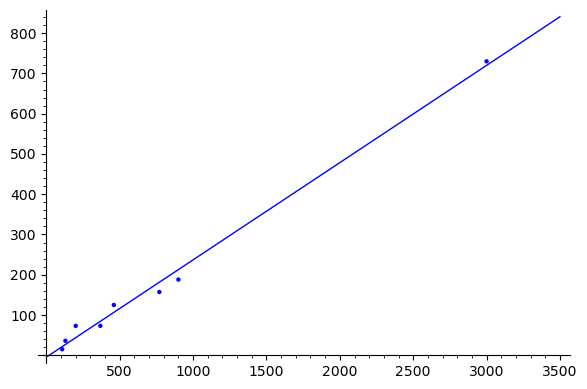

In [47]:
## get motor weight (very) approximate function of max power
dataMotor = [(130,36),(200,73),(368,73),(108,15),(460,125),(770,157),(3000,730),(900,188)] #from web search (see oct 25 2016 handwritten notes)
p_pt3 = point(dataMotor) # plot points
var('a_coef3, b_coef3, c_coef3, d_coef3, e_coef3, x_fit3, Cd_fit, n_m, P_out')
n_m = 0.8 # motor efficiency (low estimate, see journal notes 5dec2016)
model3(x_fit3) = a_coef3 + b_coef3*x_fit3 # + c_coef3*x_fit3^2
solnFit3 = find_fit(dataMotor, model3, initial_guess=None, parameters=None, variables = [x_fit3], solution_dict=true)
p_fit3 = plot(model3(x_fit3).subs(solnFit3),(x_fit3,10,3500)) # plot fitted curve
(p_pt3+p_fit3).show() # show both plots
P_out = 4*P*N/n_m # required output power from motor
m_m = (model3(P_out)/1000).subs(solnFit3).subs(soln).subs(soln) # motor mass (kg) from estimated motor power vs weight function
## evaluated battery mass from simple (derived from online data and spreasheet from actual products) // assuming a 10min complete discharge at required power from drone:
m_batt = (P_out*600/3600/130).subs(soln).subs(soln) # assuming 130 Wh/Kg
m_ctrl = 0.050 # rough estimate of controller weight (ArduPilot Mega)


In [48]:
# compute values of interest
m_calc = (4*N*b*(m_b+m_s)+m_m+m_batt+m_ctrl+m_rod*2*N*4+m_rod_p*2*N*4+m_fr*2).subs(soln).subs(soln).subs(soln) # mass of calculated components
F_Tu = 4*F_T*N - m_calc*9.81; # multiplied by N to get per rotor value (ie: 1/4 of aircraft effective thrust)
eta = (F_Tu/(4*P/n_m*N)).subs(soln).subs(soln).subs(soln); # effective efficiency # replaced old (which is now called F_Tu_simple) by one using m_calc
alpha_m_f = alpha_m.subs(soln).subs(soln); # angle of attack at top #view(eta)
maxPload = (F_Tu/9.81).subs(soln).subs(soln); # max payload of full aircraft
Ma =  Omega*R/340.29
c_C = N*c/(2*pi*R)
maxBladeStress = sigma_b.subs(soln).subs(soln)
maxSparStress = sigma_s.subs(soln).subs(soln)
EJ_b = (E_b*J_b).subs(soln)
EJ_s = (E_s*J_s).subs(soln)


In [49]:
# print optimal design for human reader:
if (postRun):
    print( 'Chord: ', round(soln[c]*100,2) ,'cm')
    print( 'theta_c: ', round(soln[theta_c]/pi*180,1)  ,'°')
    print( 'Radius: ', round(soln[R]*100,1)  ,'cm')
    print( '# of blades: ', round(soln[N])  ,'blades')
    print( 'Omega: ', round(soln[Omega],0)  ,'rad/s')
    print( 'A_rod: ', round(soln[A_rod]*1000000,2)  ,'mm^2')
    print( 'blade span: ', round(soln[b]*100,2)  ,'cm')
    print( '% infill for blade: ', round(soln[p_i],1)  ,'%')
    print( '% infill for frame: ', round(soln[p_i_fr],1)  ,'%')
    print( 'aspect ratio of alu. spar: ', round(soln[r_s],6)  ,'-')
# get numerical values
if (not optimRun):
    print( 'Effective efficiency = ', round(eta.subs(soln).n(30),5), 'N/W' )
    print( 'Effective efficiency = ', round((eta/9.81*1000).subs(soln).n(30),2), 'kg/kW' )
    print( 'eta_tot = ', round((F_T/(P/n_m)).subs(soln).subs(soln).n(30),5), 'N/W' )
    print( 'eta_max = ', round((F_T/(P)).subs(soln).subs(soln).n(30),5), 'N/W' )
    print( 'Aircraft Mass simple estimate = ', round(((1000*4*M_a).subs(soln)).n(30)), 'g' )
    print( 'Aicraft mass from calculated components: ', round(1000*m_calc.subs(soln).n(30)), 'g' )
    print( 'Max admissible AofA = ', round((alpha_m_a).subs(soln).n(30),2), 'degrees' )
    print( 'Max AofA = ', round((alpha_m_f*180/pi).subs(soln).n(30),2), 'degrees' )
    print( 'Max aircraft payload = ', round((1000*maxPload).subs(soln).n(30)), 'g' )
    print( 'Aircraft power = ', round((4*(P*N).subs(soln).subs(soln).subs(soln)).n(30),1), 'W' )
    print( 'Mach = ', round(Ma.subs(soln).n(30),3) )
    print( 'Reynolds number = ', round(Reynolds.subs(soln).n(30)) )
    print( 'total chord over circumference ratio = ', round(c_C.subs(soln).n(30),4) )
    print( 'Ang. vel. for such performance: ', (Omega*60/(2*pi)).subs(soln).n(30), 'rpm' )
    print( 'Mass of individual PLA blade: ', round(1000*(m_b*b).subs(soln).n(30),2), 'g' )
    print( 'Mass of individual alu spar: ', round(1000*1000*(m_s*b).subs(soln).n(30),3), 'mg' )
    print( 'Mass of motor: ', round(1000*m_m.subs(soln).n(30),1), 'g' )
    print( 'Mass of battery: ', round(1000*m_batt.subs(soln).n(30),1), 'g' )
    print( 'Mass of each frame beam = ', round(1000*(m_fr).subs(soln).subs(soln).subs(soln).n(30),1), ' g' )
    print( 'Total mass of frame beams = ', round(1000*(2*m_fr).subs(soln).subs(soln).subs(soln).n(30),1), ' g' )
    print( 'Blade dims: c = ', round(100*(c).subs(soln).n(30),2), 'cm, b = ', round(100*b.subs(soln).n(30),2), 'cm, h_b = ', round(1000*(h_b).subs(soln).n(30),2), 'mm, h_b_i = ', round(1000*(h_b_i).subs(soln).n(30),3), 'mm' )
    #soln[x]=(b/2).subs(soln)
    print( 'Dimensions of alu. spar: ', round(1000*h_s.subs(soln).n(30),3), ' x ', round(1000*t_s.subs(soln).n(30),4), 'mm' )
    print( 'Max stresses at center: blade = ', round(1e-6*maxBladeStress.subs(x=0).subs(soln).n(30),2), 'spar = ', round(1e-6*maxSparStress.subs(x=0).subs(soln).n(30),2), 'MPa' )
    print( 'Max defl. at center = ', round(1000*w.subs(soln).subs(soln).subs(soln).subs(x=0).n(30),4), ' mm' )
    print( 'q_w = ', round(1000*q_w.subs(soln).subs(soln).subs(soln).n(30),4), ' mm' )
    print( 'C_L = ', C_L.subs(soln).subs(soln).subs(soln).n(30) )
    print( 'EJ_e = ', EJ_e.subs(soln).subs(soln).n(30), 'EJ_b = ', EJ_b.subs(soln).subs(soln).n(30), 'EJ_s = ', EJ_s.subs(soln).subs(soln).n(30) )
    print( 'max abs. strain at midpoint : blade = ', (epsilon_b*100).subs(soln).subs(soln).subs(soln).subs(x=0).n(30), '%, spar = ', (epsilon_s*100).subs(soln).subs(soln).subs(soln).subs(x=0).n(30), '%' )
    print( 'proprotion of flexural rigidity from blade: ', round((100*(E_b*I_b_A)/EJ_e).subs(soln).subs(soln).n(30),2), '% and from spar: ', round((100*(E_s*J_s)/EJ_e).subs(soln).subs(soln).n(30),2) , '%')
    #print 'static torsion (clamped end) = ', view(torsion)
    print( 'max torsion delay (at free end) = ', (phi_b_max.subs(soln)/pi*180).n(30), 'deg' )
    print( 'max torsion induced stress (uncoupled) = ', tau_b_m.subs(soln).n(30), 'Pa' )
    print( 'torsion blade natural freq. = ', n_b_t.subs(soln).n(30), '(rad/s)' )
    print( 'torsion blade not-to-exceed freq. to respect imposed tip angle increase = ', (r_t_bt*n_b_t).subs(soln).n(30), '(rad/s)' )
    print( 'Min admissible chord without changing height selection = ', minC.subs(soln).n(30), 'm' )
    print( 'Per rod maximum axial forces in tension', f_rod_max.subs(soln).subs(soln).subs(soln).n(30), 'N' )
    print( 'Per rod maximum centrifugal forces ', round((R*Omega^2*((m_b+m_s)/4+m_rod/2)).subs(soln).subs(soln).n(30),3), ' N')
    print( 'Ratio of aero to centrifugal forces in rods (should not go much beyond one, or buckling) ', round((f_rod_max / (R*Omega^2*((m_b+m_s)/4+m_rod/2))).subs(soln).subs(soln).subs(soln).n(30),3) ) 
    print( 'Average thrust per blade', F_T.subs(soln).subs(soln).subs(soln).n(30), 'N' )
    print( 'Per rod maximum torque', T_rod.subs(soln).subs(soln).subs(soln).n(30), 'Nm' )
    #print 'This must be negative to satisfy A_rod analytic solution:', A_rod_cond.subs(soln).subs(soln).subs(soln).n(30)
    print( 'and pitch/pivot rod is ', round(1000*b_rod.subs(soln).subs(soln).subs(soln).n(30),3), ' by ', round(1000*d_rod.subs(soln).subs(soln).subs(soln).n(30),3), 'mm' )
    print( 'Inner radius of frame\'s inner beam = ', round(1000*R_fr1_i.subs(soln).subs(soln).subs(soln).n(30),2), 'mm' )
    print( 'Inner radius of frame\'s outer beam = ', round(1e3*R_fr2_i.subs(soln).subs(soln).subs(soln).n(30),2), 'mm' )
    print( 'Drone width (1xL_fr): ', round(100*L_fr.subs(soln).subs(soln).subs(soln).n(30),2), ' cm')
    print( 'Rotor solidity: ', round(sigma.subs(soln).subs(soln).subs(soln).n(30),4) )
    
    A_disk = 2*R*b
    DL = (F_T*N/9.81)/A_disk
    PL = (F_T/9.81)/(P/1000)
    P_ideal = sqrt((F_T*N)^3/(2*rho*A_disk))
    FM = P_ideal/(P*N)
    print( 'Disk Loading = ', round(DL.subs(soln).subs(soln).subs(soln).n(30),2), 'kg/m^2' )
    print( 'Power Loading = ', round(PL.subs(soln).subs(soln).subs(soln).n(30),2), 'kg/kW' )
    print( 'Figure Of Merit (conventional rotor) = ', round(FM.subs(soln).subs(soln).subs(soln).n(30),3), '' )

Chord:  2.01 cm
theta_c:  14.9 °
Radius:  22.2 cm
# of blades:  2 blades
Omega:  282 rad/s
A_rod:  1.99 mm^2
blade span:  3.8 cm
% infill for blade:  90.0 %
% infill for frame:  90.0 %
aspect ratio of alu. spar:  0.04 -
Effective efficiency =  0.01864 N/W
Effective efficiency =  1.9 kg/kW
eta_tot =  0.07008 N/W
eta_max =  0.0876 N/W
Aircraft Mass simple estimate =  1325 g
Aicraft mass from calculated components:  349 g
Max admissible AofA =  9.97 degrees
Max AofA =  9.97 degrees
Max aircraft payload =  127 g
Aircraft power =  53.3 W
Mach =  0.184
Reynolds number =  86059
total chord over circumference ratio =  0.0288
Ang. vel. for such performance:  2692.2379 rpm
Mass of individual PLA blade:  1.38 g
Mass of individual alu spar:  0.0 mg
Mass of motor:  11.5 g
Mass of battery:  85.4 g
Mass of each frame beam =  86.8  g
Total mass of frame beams =  173.7  g
Blade dims: c =  2.01 cm, b =  3.8 cm, h_b =  2.41 mm, h_b_i =  0.01 mm
Dimensions of alu. spar:  0.01  x  0.0004 mm
Max stresses at

In [50]:
# get functions and their variables for objective function and constraints

eta_c = -eta # objective function to minimize; make eta as large a possible

alpha_m_c = 1000*(alpha_m_f - alpha_m_a/180*pi); # want AoA smaller than alpha_m_a in "f() <= 0" format for sagemath, constraint g1 ## #CORRECTION_MARS2021## : ajouté un multiplicateur de 1000 pour avoir plus de poids dans le calcul...
Reynolds_c = 40000 - Reynolds; # want Reynolds above 40 000  in "f() <= 0" format for sagemath, constraint g2 (this is for NACA0012)
sigma_rod_c = sigma_rod_c1.subs(soln).subs(soln) # rod constraint
sigma_b_c = (sigma_b^2 - sigma_b_y^2).subs(x=0).subs(soln).subs(soln) # blade pla constraint
sigma_s_c = (sigma_s^2 - sigma_s_y^2).subs(x=0).subs(soln).subs(soln) # blade alu spar constraint
tau_b_m_c = (tau_b_m - sigma_b_y).subs(soln) # blade max stress induced by torsion constraint
Omega_t_m_c = (Omega - r_t_bt*n_b_t).subs(soln) # constraint on max freq to avoid blade torsion angle distorsion

print( 'variables for objective function eta_c: ', eta_c.variables() )
print( 'variables for constraint function alpha_m_c: ', alpha_m_c.variables() )
print( 'variables for constraint function Reynolds_c: ', Reynolds_c.variables() )
print( 'variables for constraint function sigma_rod_c: ', sigma_rod_c.variables() )
print( 'variables for constraint function sigma_b_c: ', sigma_b_c.variables() )
print( 'variables for constraint function sigma_s_c: ', sigma_s_c.variables() )
print( 'variables for constraint function tau_b_m_c: ', tau_b_m_c.variables() )
print( 'variables for constraint function Omega_t_m_c: ', Omega_t_m_c.variables() )

variables for objective function eta_c:  ()
variables for constraint function alpha_m_c:  ()
variables for constraint function Reynolds_c:  (Omega, R, c)
variables for constraint function sigma_rod_c:  (N, R, c)
variables for constraint function sigma_b_c:  (N, R, c)
variables for constraint function sigma_s_c:  (N, R, c)
variables for constraint function tau_b_m_c:  ()
variables for constraint function Omega_t_m_c:  ()


In [51]:
# verifying if values match the ones in dakota:
if (postRun):
    print( eta_c.n(128) )
    print( alpha_m_c.n(128) )
    print( Reynolds_c.subs(soln).n(128) )
    print( sigma_rod_c.subs(soln).n(128) )
    print( sigma_b_c.subs(soln).n(128) )
    print( sigma_s_c.subs(soln).n(128) )
    print( tau_b_m_c.n(53) )
    print( Omega_t_m_c.n(53) )

-0.018641019124073871526312426562483730110
-3.4187630734837038831638247103615797377e-6
-46059.226546025383868254721164703369141
-2.1694343586116178486785776693806340031
-4.3663637667658338042613140157311946977e9
-5.7592416420045848162753825096877690901e16
-2.79756395947683e7
-452.911999927444


In [52]:
# iterative cpp generation replaces previous manual approach
# print in c++ format for Dakota optimizer
if (getCPP):
    from sympy.utilities.codegen import codegen
    import numpy
    CGvarName = numpy.array(['eta','alpha_m_c','Reynolds_c','sigma_rod_c','sigma_b_c','sigma_s_c','tau_b_m_c','Omega_t_m_c']) # obj funct must be first
    CGvar = numpy.array([eta_c,alpha_m_c,Reynolds_c,sigma_rod_c,sigma_b_c,sigma_s_c,tau_b_m_c,Omega_t_m_c])
    allVars = CGvar[0].variables() # accessing all optim vars as being the ones of the objective function
    CG_tl = [] # initializing codegen tuple list: [(name, Eqn), (name, Eqn),...]
    for iVAR in (0..len(CGvar)-1):
        CG_tl.append((CGvarName[iVAR], CGvar[iVAR]._sympy_())); # appending codegen tuple list
        for iCG in (0..len(allVars)-1):
            CGName = 'd'+CGvarName[iVAR]+'_%s' % allVars[iCG] # derivative variable name
            CGDeriv = derivative(CGvar[iVAR],allVars[iCG]) # derivative itself
            CG_tl.append((CGName,CGDeriv._sympy_())) # appending codegen tuple list
    [(c_name, AllEqnsCpp), (h_name, AllEqnsH)] = codegen(CG_tl, "C", "test", 'project', to_files=False, header=False, empty=False, argument_sequence=None, global_vars=None)
if (getCPP):
    fCG=open('cppEquations.cpp','w')
    fCG.write('//Codegen header, equations, and derivatives for objective and constraint functions = \n')
    fCG.write(AllEqnsH)
    fCG.write(AllEqnsCpp)
    fCG.close()

In [53]:
### generate cpp file to compile prior to running Dakota
if (getCPP):
    nCGvar = len(allVars) # number of variables in objective function
    fDAK=open('cycloidalEfficiency.cpp','w')
    fDAK.write('// Based on the code cited below, adapted for cycloidal rotor function by Louis Gagnon, 2016\n/*  _______________________________________________________________________\n\n    DAKOTA: Design Analysis Kit for Optimization and Terascale Applications\n    Copyright 2014 Sandia Corporation.\n    This software is distributed under the GNU Lesser General Public License.\n    For more information, see the README file in the top Dakota directory.\n    _______________________________________________________________________ */\n\n#include <cstdlib>\n#include <iostream>\n#include <fstream>\n#include <string>\n#include <vector>\n#include <map>\n#include <algorithm>\n#include <cctype>\n//#include "./mpreal.h" // implements the c++ wrapper for mpfr\n//using mpfr::mpreal;\n// Required precision of computations in decimal digits\n// Play with it to check different precisions\n//const int digits = 50;\n//const mpreal pi = mpfr::const_pi();\n#include "./cppEquations.cpp"  // functions (doubles-now mpreals) of objective, constraints, and their derivatives \n\nenum var_t {')
    for iCG in (0..nCGvar-2):
        fDAK.write(' %s_map,' % allVars[iCG])
    fDAK.write(' %s_map };' % allVars[nCGvar-1])
    fDAK.write('\n\nint main(int argc, char** argv)\n{\n\n  // This application program reads and writes parameter and response data \n  // directly so no input/output filters are needed.\n  std::ifstream fin(argv[1]);\n  if (!fin) {\n    std::cerr << "\\nError: failure opening " << argv[1] << std::endl;\n    exit(-1);\n  }\n  size_t i, j, num_vars, num_fns, num_deriv_vars;\n  std::string vars_text, fns_text, dvv_text;\n\n\n  // Setup default precision for all subsequent computations\n  // MPFR accepts precision in bits - so we do the conversion\n//  mpreal::set_default_prec(mpfr::digits2bits(digits));\n//  const mpreal pi = mpfr::const_pi();\n\n  // define the std::string to enumeration map\n  std::map<std::string, var_t> var_t_map;\n')
    for iCG in (0..nCGvar-1):
        fDAK.write('  var_t_map["%s_txt"] = %s_map;\n' % (str(allVars[iCG]).lower(),allVars[iCG]))
    fDAK.write('\n  // Get the parameter std::vector and ignore the labels\n  fin >> num_vars >> vars_text;\n//  std::map<var_t, mpreal> vars;\n  std::map<var_t, double> vars;\n  std::vector<var_t> labels(num_vars);\n//  mpreal var_i; std::string label_i; var_t v_i;\n  double var_i; std::string label_i; var_t v_i;\n  std::map<std::string, var_t>::iterator v_iter;\n  for (i=0; i<num_vars; i++) {\n    fin >> var_i >> label_i;\n    transform(label_i.begin(), label_i.end(), label_i.begin(),\n	      (int(*)(int))tolower);\n    v_iter = var_t_map.find(label_i);\n    if (v_iter == var_t_map.end()) {\n      std::cerr << "Error: label \\"" << label_i\n		<< "\\" not supported in analysis driver." << std::endl;\n      exit(-1);\n    }\n    else\n      v_i = v_iter->second;\n    vars[v_i] = var_i;\n    labels[i] = v_i;\n  }\n\n  // Get the ASV std::vector and ignore the labels\n  fin >> num_fns >> fns_text;\n  std::vector<short> ASV(num_fns);\n  for (i=0; i<num_fns; i++) {\n    fin >> ASV[i];\n    fin.ignore(256, \'\\n\');\n  }\n\n  // Get the DVV std::vector and ignore the labels\n  fin >> num_deriv_vars >> dvv_text;\n  std::vector<var_t> DVV(num_deriv_vars);\n  unsigned int dvv_i;\n  for (i=0; i<num_deriv_vars; i++) {\n    fin >> dvv_i;\n    fin.ignore(256, \'\\n\');\n    DVV[i] = labels[dvv_i-1];\n  }\n\n  if (num_vars != %s) {\n' % nCGvar)
    fDAK.write('\n    std::cerr << "Wrong number of variables for the cycloidal rotor problem\\n";\n    exit(-1);\n  }\n  if (num_fns < 1 || num_fns > %s) { // 1 fn -> opt, 2 fns -> least sq\n' % len(CGvarName))
    fDAK.write('\n\n    std::cerr << "Wrong number of functions in cycloidal rotor problem\\n";\n    exit(-1);\n  }\n\n\n  // Compute and output responses\n//  bool least_sq_flag = (num_fns > 1) ? true : false;\n\n//  mpreal \n  double ')
    for iCG in (0..nCGvar-2):
        fDAK.write(' %s = vars[%s_map],' % (allVars[iCG],allVars[iCG]))
    fDAK.write(' %s = vars[%s_map];' % (allVars[nCGvar-1],allVars[nCGvar-1]))
    fDAK.write('\n\n  \n\n  std::ofstream fout(argv[2]);\n  if (!fout) {\n    std::cerr << "\\nError: failure creating " << argv[2] << std::endl;\n    exit(-1);\n  }\n  fout.precision(15); // 16 total digits\n  fout.setf(std::ios::scientific);\n  fout.setf(std::ios::right);\n  \n\n  \n  // ASV[i] & 1 when looking for result of function i and & 2 when looking for gradient(s) of function i\n')
    for iVAR in (0..len(CGvar)-1):
        if iVAR==0:
            fDAK.write('  // *** objective function (f):\n')
        else:
            fDAK.write('  // *** constraint function (c%s):\n' % CGvarName[iVAR])
        fDAK.write('  if (ASV[%s] & 1) {    fout << "                     " <<\n	  (isnan(%s%s) ? 1.0 : %s%s)   << " ' % (iVAR,CGvarName[iVAR],CGvar[iVAR].variables(),CGvarName[iVAR],CGvar[iVAR].variables()))
        if iVAR==0:
            fDAK.write('f\\n"; // objective function\n    }\n')
        else:
            fDAK.write('\\n"; // *** constraint function c%s (%s):\n    }\n' % (iVAR,CGvarName[iVAR]))
    fDAK.write('\n\n')
    for iVAR in (0..len(CGvar)-1): # iterating over functions
        curVars = CGvar[iVAR].variables() # accessing variables of the current constraint (or objective) function
        fDAK.write('    if (ASV[%s] & 2) { // **** d(%s)/dx:\n' % (iVAR,CGvarName[iVAR]))
        fDAK.write('      fout << "[ ";\n      for (i=0; i<num_deriv_vars; i++)\n	switch (DVV[i]) {\n')
        for iCG in (0..len(allVars)-1): # iterating over variables
            varsDcur = derivative(CGvar[iVAR],allVars[iCG]).variables() # variables of the current deriv of the current constraint or function
            fDAK.write('	case %s_map: fout << (isnan(d%s_%s%s) ? 0.0 : d%s_%s%s) << \' \'; break;  // d(%s)/dx%s\n' % (allVars[iCG],CGvarName[iVAR],allVars[iCG],varsDcur,CGvarName[iVAR],allVars[iCG],varsDcur,CGvarName[iVAR],iCG+1))
        fDAK.write('	}\n      fout << "]\\n";\n    }\n    ')
    fDAK.write('\n    \n    if (ASV[0] & 4) { // **** d^2f/dx^2:  (Hessian)\n	// disabled\n    }\n  \n  fout.flush();\n  fout.close();\n  return 0;\n}\n')
    fDAK.close()